In [17]:
import os
import pandas as pd
import numpy as np
import glob
import csv
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.style.use('bmh')

In [18]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import numpy as np
import math

def jitter(v):
    """
    Calculate jitter in a vectorized form. Time axis is assumed to be 0.
    We assume, that `v` is 2D array.
    """
    return np.sum(np.abs(v.values[1:] - v.values[:-1]), axis=0)/v.shape[0]


def mean_crossing_rate(v):
        """
        Calculate MCR in a vectorized form. Time axis is assumed to be 0.
        We assume, that `v` is 2D array.
        """

        m = v.mean(axis=0)
        crossings = np.logical_or(np.logical_and((v.values > m)[1:], (v.values < m)[:-1]), # crossing downwards
                                  np.logical_and((v.values < m)[1:], (v.values > m)[:-1])) # crossing upwards
        return np.mean(crossings, axis=0)
    


In [19]:
''' v is a sample : assumed tobe a 2d array'''
# mean auto correlation
def acf_mean(v):
    return stattools.acf(v).mean()
# standard deviation auto correlation
def acf_std(v):
    return stattools.acf(v).std()
# mean auto covariance   
def acv_mean(v):
    return stattools.acovf(v).mean()
# standard deviation auto covariance
def acv_std(v):
    return stattools.acovf(v).std()
    
    
    

In [20]:
def turn(df):
    df['turn'] = np.sign(round(df.course/10).diff()) 
    df['turn'][0] = 0.0
    df['turn_1_sec_ago'] = df['turn'].shift(1) 
    df['turn_2_sec_ago'] = df['turn'].shift(2)
    df['turn_3_sec_ago'] = df['turn'].shift(3)
    df['right_turn'] = df[['turn_1_sec_ago','turn_2_sec_ago','turn_3_sec_ago']].max(axis=1) == 1 # check if right turn in the last 3 seconds
    df['left_turn'] = df[['turn_1_sec_ago','turn_2_sec_ago','turn_3_sec_ago']].min(axis=1) == -1
    df.drop(['turn_1_sec_ago','turn_2_sec_ago','turn_3_sec_ago'], axis = 1, inplace = True)
    return df


### read files into a dataframe

In [21]:
#reading the files:
DATA_DIR = "./nexar/"
!ls nexar

f1  f2	high_rated-2018-11-24  zero_rated-2018-11-24


In [22]:
samples_accel = glob.glob("nexar/*/*/*_Accel.csv")
samples_gyro=glob.glob("nexar/*/*/*_Gyro.csv")
samples_gps=glob.glob("nexar/*/*/*_GPS.csv")
print("there are {}  accel samples".format(len(samples_accel)))
print("there are {}  gyro samples".format(len(samples_gyro)))
print("there are {}  GPS samples".format(len(samples_gps)))
samples_gyro[:5], samples_accel[:5],samples_gps[:5]


there are 4133  accel samples
there are 4010  gyro samples
there are 4138  GPS samples


(['nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_Gyro.csv',
  'nexar/zero_rated-2018-11-24/0899c7acdc74c1d2fc16b3ba7dff47c6/0899c7acdc74c1d2fc16b3ba7dff47c6_Gyro.csv',
  'nexar/zero_rated-2018-11-24/049b7df2a36aad19543151765819a213/049b7df2a36aad19543151765819a213_Gyro.csv',
  'nexar/zero_rated-2018-11-24/0515cba67277eed2d285e802421ba4da/0515cba67277eed2d285e802421ba4da_Gyro.csv',
  'nexar/zero_rated-2018-11-24/02680761599287696ed79852c0dd620a/02680761599287696ed79852c0dd620a_Gyro.csv'],
 ['nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_Accel.csv',
  'nexar/zero_rated-2018-11-24/0899c7acdc74c1d2fc16b3ba7dff47c6/0899c7acdc74c1d2fc16b3ba7dff47c6_Accel.csv',
  'nexar/zero_rated-2018-11-24/049b7df2a36aad19543151765819a213/049b7df2a36aad19543151765819a213_Accel.csv',
  'nexar/zero_rated-2018-11-24/0515cba67277eed2d285e802421ba4da/0515cba67277eed2d285e802421ba4da_Accel.csv',
  'nexar/zero_rated-201

In [23]:
def get_ids(fname):
    """Calculate `sample_id` and short filename."""
    start_dir, filename = os.path.split(fname)
    base_dir, sample_id = os.path.split(start_dir)
    _, sample_class = os.path.split(base_dir)
    sample_class= sample_class
    return (sample_id, sample_class, filename)


## Read file GPS , gyro and of acceleration to see they are syncronic in time

In [24]:
#Let's read 1 file of gyro and 1 files of accelerometer:
accel_df= pd.read_csv("nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_Gyro.csv")
gyro_df= pd.read_csv("nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_Accel.csv")
gps_df= pd.read_csv("nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_GPS.csv")
accel_df["timestamp"] = pd.to_datetime(accel_df['timestamp'], unit="s")
gyro_df["timestamp"] = pd.to_datetime(gyro_df['timestamp'], unit="s")
gps_df["timestamp"] = pd.to_datetime(gps_df['timestamp'], unit="s")
# gyro_df=gyro_df.resample('1S', on="timestamp").mean()
# accel_df=accel_df.resample('1S', on="timestamp").mean()
# gps_df=gps_df.resample('1S', on="timestamp").mean()
gyro_df.set_index('timestamp',inplace=True)
accel_df.set_index('timestamp',inplace=True)
gps_df.set_index('timestamp',inplace=True)
accel_df.head()

,signal_x,signal_y,signal_z
timestamp,,,
2018-10-19 12:40:58.012158871,-0.0293,-0.0769,-0.0446
2018-10-19 12:40:58.031355143,-0.0067,-0.0195,-0.0598
2018-10-19 12:40:58.050580978,-0.0042,0.0256,-0.0720
2018-10-19 12:40:58.069776058,-0.0146,0.0433,-0.0751
2018-10-19 12:40:58.089001894,-0.0348,0.0470,-0.0659


In [25]:
print("Accel shape: {}, gyro shape: {} gps shape {}".format(accel_df.shape, gyro_df.shape,gps_df.shape))
gyro_df.head()


Accel shape: (2082, 3), gyro shape: (2082, 3) gps shape (40, 7)


,signal_x,signal_y,signal_z
timestamp,,,
2018-10-19 12:40:58.012079000,-0.116,-0.199,-1.052
2018-10-19 12:40:58.031274080,-0.120,-0.199,-1.005
2018-10-19 12:40:58.050499916,-0.110,-0.191,-0.976
2018-10-19 12:40:58.069696188,-0.088,-0.180,-0.964
2018-10-19 12:40:58.088922024,-0.081,-0.172,-0.965


In [26]:
print(gps_df.shape)
print(gps_df[gps_df.isnull().any(axis=1)].shape)
gps_df.head()
turn(gps_df).head()

(40, 7)
(0, 7)


,longitude,latitude,horizontal_accuracy,vertical_accuracy,altitude,speed,course,turn,right_turn,left_turn
timestamp,,,,,,,,,,
2018-10-19 12:40:58.472000122,-87.476144,41.570532,5.360,0.0,146.113159,5.15,56.700001,0.0,False,False
2018-10-19 12:40:59.480000019,-87.476101,41.570535,6.432,0.0,147.197327,5.23,61.500000,0.0,False,False
2018-10-19 12:41:00.486000061,-87.476043,41.570565,8.576,0.0,146.460571,5.79,61.700001,0.0,False,False
2018-10-19 12:41:01.477999926,-87.475960,41.570619,6.432,0.0,146.643921,7.58,56.000000,0.0,False,False
2018-10-19 12:41:02.460000038,-87.475856,41.570676,6.432,0.0,147.735413,8.20,53.299999,-1.0,False,False


In [31]:
files_accel=pd.DataFrame([get_ids(sample) for sample in samples_accel],
                     columns=["sample_id", "class", "accel_file"])
files_gyro=pd.DataFrame([get_ids(sample) for sample in samples_gyro],
                     columns=["sample_id", "class", "gyro_file"])
files_gps=pd.DataFrame([get_ids(sample) for sample in samples_gps],
                     columns=["sample_id", "class", "gps_file"])

In [32]:
print("Accel: number of dangerous rides {}".format(files_accel[files_accel['class']=="high_rated-2018-11-24"].shape[0]))
print("Accel: number of not dangerous rides {}".format(files_accel[files_accel['class']=="zero_rated-2018-11-24"].shape[0]))
print("Accel:number of files: {}".format(files_accel.shape[0]))
print("Gyro: number of dangerous rides {}".format(files_gyro[files_gyro['class']=="high_rated-2018-11-24"].shape[0]))
print("Gyro: number of not dangerous rides {}".format(files_gyro[files_gyro['class']=="zero_rated-2018-11-24"].shape[0]))
print("Gyro:number of files: {}".format(files_gyro.shape[0]))
print("Gps: number of dangerous rides {}".format(files_gps[files_gps['class']=="high_rated-2018-11-24"].shape[0]))
print("Gps: number of not dangerous rides {}".format(files_gps[files_gps['class']=="zero_rated-2018-11-24"].shape[0]))
print("Gps:number of files: {}".format(files_gps.shape[0]))

Accel: number of dangerous rides 2222
Accel: number of not dangerous rides 1911
Accel:number of files: 4133
Gyro: number of dangerous rides 2214
Gyro: number of not dangerous rides 1796
Gyro:number of files: 4010
Gps: number of dangerous rides 2223
Gps: number of not dangerous rides 1915
Gps:number of files: 4138


In [33]:
files_gps.tail()


,sample_id,class,gps_file
4133,19f92c0d70ffab7a4a1ce0eb170112a3,high_rated-2018-11-24,19f92c0d70ffab7a4a1ce0eb170112a3_GPS.csv
4134,3be8fa37d1866c50e89716839e25e90a,high_rated-2018-11-24,3be8fa37d1866c50e89716839e25e90a_GPS.csv
4135,31ae47b0a0c883ede3a263daa9037ea7,high_rated-2018-11-24,31ae47b0a0c883ede3a263daa9037ea7_GPS.csv
4136,a2a7ab14e2a265cd1f786e1e13a80b23,high_rated-2018-11-24,a2a7ab14e2a265cd1f786e1e13a80b23_GPS.csv
4137,83d25b2b1066b26bf188f6c536a1caa2,high_rated-2018-11-24,83d25b2b1066b26bf188f6c536a1caa2_GPS.csv


In [34]:
files_accel['class_number']= files_accel['class'].map({"zero_rated-2018-11-24":0,"high_rated-2018-11-24":1})
files_gyro['class_number']= files_gyro['class'].map({"zero_rated-2018-11-24":0,"high_rated-2018-11-24":1})
files_gps['class_number']= files_gps['class'].map({"zero_rated-2018-11-24":0,"high_rated-2018-11-24":1})

### Merge the two files

In [35]:
files=files_accel.merge(files_gyro,left_on='sample_id', right_on='sample_id', how="inner" ,suffixes=('_accel', '_gyro'))
files=files.merge(files_gps,left_on='sample_id', right_on='sample_id', how="inner" ,suffixes=("_",'_gps'))
print(files.shape)


(4006, 10)


In [36]:
files.head()

,sample_id,class_accel,accel_file,class_number_accel,class_gyro,gyro_file,class_number_gyro,class,gps_file,class_number
0,01664c5ac370136abc20d7ac52d0ec48,zero_rated-2018-11-24,01664c5ac370136abc20d7ac52d0ec48_Accel.csv,0,zero_rated-2018-11-24,01664c5ac370136abc20d7ac52d0ec48_Gyro.csv,0,zero_rated-2018-11-24,01664c5ac370136abc20d7ac52d0ec48_GPS.csv,0
1,0899c7acdc74c1d2fc16b3ba7dff47c6,zero_rated-2018-11-24,0899c7acdc74c1d2fc16b3ba7dff47c6_Accel.csv,0,zero_rated-2018-11-24,0899c7acdc74c1d2fc16b3ba7dff47c6_Gyro.csv,0,zero_rated-2018-11-24,0899c7acdc74c1d2fc16b3ba7dff47c6_GPS.csv,0
2,049b7df2a36aad19543151765819a213,zero_rated-2018-11-24,049b7df2a36aad19543151765819a213_Accel.csv,0,zero_rated-2018-11-24,049b7df2a36aad19543151765819a213_Gyro.csv,0,zero_rated-2018-11-24,049b7df2a36aad19543151765819a213_GPS.csv,0
3,0515cba67277eed2d285e802421ba4da,zero_rated-2018-11-24,0515cba67277eed2d285e802421ba4da_Accel.csv,0,zero_rated-2018-11-24,0515cba67277eed2d285e802421ba4da_Gyro.csv,0,zero_rated-2018-11-24,0515cba67277eed2d285e802421ba4da_GPS.csv,0
4,02680761599287696ed79852c0dd620a,zero_rated-2018-11-24,02680761599287696ed79852c0dd620a_Accel.csv,0,zero_rated-2018-11-24,02680761599287696ed79852c0dd620a_Gyro.csv,0,zero_rated-2018-11-24,02680761599287696ed79852c0dd620a_GPS.csv,0


#### split the data to train /test 

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(files[['sample_id',"class_accel","accel_file","gyro_file","gps_file"]], files['class_number_accel'], test_size=0.2, random_state=42)

In [38]:
print(X_train.shape)
X_train.rename(columns={"class_accel": "class"}, inplace=True)
X_test.rename(columns={"class_accel": "class"}, inplace=True)
X_train.head() 

(3204, 5)


,sample_id,class,accel_file,gyro_file,gps_file
2488,17a401f5d7a553dc1e3c247dfe81316c,high_rated-2018-11-24,17a401f5d7a553dc1e3c247dfe81316c_Accel.csv,17a401f5d7a553dc1e3c247dfe81316c_Gyro.csv,17a401f5d7a553dc1e3c247dfe81316c_GPS.csv
1756,09e74296a21b3758f4da9806daacf855,zero_rated-2018-11-24,09e74296a21b3758f4da9806daacf855_Accel.csv,09e74296a21b3758f4da9806daacf855_Gyro.csv,09e74296a21b3758f4da9806daacf855_GPS.csv
423,033684d028afa4f6d68b9e36e013d21b,zero_rated-2018-11-24,033684d028afa4f6d68b9e36e013d21b_Accel.csv,033684d028afa4f6d68b9e36e013d21b_Gyro.csv,033684d028afa4f6d68b9e36e013d21b_GPS.csv
2997,2783dd689a25f2101da3f9c6ab83cc2d,high_rated-2018-11-24,2783dd689a25f2101da3f9c6ab83cc2d_Accel.csv,2783dd689a25f2101da3f9c6ab83cc2d_Gyro.csv,2783dd689a25f2101da3f9c6ab83cc2d_GPS.csv
2684,18edfd6c19c9a811047cfffab9688932,high_rated-2018-11-24,18edfd6c19c9a811047cfffab9688932_Accel.csv,18edfd6c19c9a811047cfffab9688932_Gyro.csv,18edfd6c19c9a811047cfffab9688932_GPS.csv


In [39]:
y_train.head()

2488    1
1756    0
423     0
2997    1
2684    1
Name: class_number_accel, dtype: int64

In [40]:
def generate_features(base_dir, sample_class, sample_id, filename):
    # Reading
    fullname = os.path.join(base_dir, sample_class, sample_id, filename)
#     print("full name: {}".format(fullname))
    sample = pd.read_csv(fullname)
#     print(sample.shape)
#     print(sample.head()) 
    # Handling timestamps and spacing
    sample["timestamp"] = pd.to_datetime(sample['timestamp'], unit="s")
    
    
    
    sample = sample.resample('1S', on="timestamp").mean()
#     print(sample.shape)
#     print(sample.head())
    
    # Acceleration
    sample["magnitude"] = np.sqrt(np.square(sample).sum(axis=1))
    
    # Statistical aggregates

    # Note the trickery to get right format from pandas
    # without manual renaming
    aggs = (sample
            .apply(["mean", "std", "min", "max","median","skew","kurtosis",acf_mean,acf_std,acv_mean,acv_std,jitter,mean_crossing_rate])
            .unstack()
            .reset_index())
    aggs["feature"] = aggs["level_0"].str.cat(aggs["level_1"], sep="_{}_".format(filename.split("_")[1].split(".")[0]))

    return aggs.set_index("feature")[0]
    

In [43]:
def generate_features_gps(base_dir, sample_class, sample_id, filename):
     # Reading
    fullname = os.path.join(base_dir, sample_class, sample_id, filename)
#     print("full name: {}".format(fullname))
    sample = pd.read_csv(fullname)
    # Handling timestamps and spacing
#     sample=turn(sample)
   
    sample["timestamp"] = pd.to_datetime(sample['timestamp'], unit="s")
    
    sample = sample.resample('1S', on="timestamp").mean()

#     # taking the speed and course only  and add "turn" feature
#     right=np.sum(sample['right_turn'])
#     left= np.sum(sample['left_turn'])
#     sample.drop(['right_turn','left_turn','turn'],axis=1, inplace=True)
    sample=sample[["speed","course"]]
    # Statistical aggregates

    # Note the trickery to get right format from pandas
    # without manual renaming
    aggs = (sample
            .apply(["mean", "std", "min", "max","median","skew","kurtosis",acf_mean,acf_std,acv_mean,acv_std,jitter,mean_crossing_rate])
            .unstack()
            .reset_index())
    aggs["feature"] = aggs["level_0"].str.cat(aggs["level_1"], sep="_{}_".format(filename.split("_")[1].split(".")[0]))

    return aggs.set_index("feature")[0]

In [44]:
 #generate features for 1 sample
ac=generate_features(DATA_DIR, *X_train[["class", "sample_id", "accel_file"]].loc[0,:].tolist())
gy=generate_features(DATA_DIR, *X_train[["class", "sample_id", "gyro_file"]].loc[0,:].tolist())
gps=generate_features_gps(DATA_DIR, *X_train[["class", "sample_id", "gps_file"]].loc[0,:].tolist())
print(ac.shape, gy.shape)


(52,) (52,)


In [46]:
gps

feature
speed_GPS_mean                    10.527750
speed_GPS_std                      3.704962
speed_GPS_min                      2.560000
speed_GPS_max                     15.020000
speed_GPS_median                  11.370000
speed_GPS_skew                    -0.628516
speed_GPS_kurtosis                -0.715038
speed_GPS_acf_mean                 0.012500
speed_GPS_acf_std                  0.371387
speed_GPS_acv_mean                 0.167295
speed_GPS_acv_std                  4.970489
speed_GPS_jitter                   0.604250
speed_GPS_mean_crossing_rate       0.051282
course_GPS_mean                   66.725000
course_GPS_std                    18.081819
course_GPS_min                    49.500000
course_GPS_max                   107.099998
course_GPS_median                 58.400000
course_GPS_skew                    1.026393
course_GPS_kurtosis               -0.086366
course_GPS_acf_mean                0.012500
course_GPS_acf_std                 0.377806
course_GPS_acv_mean     

In [47]:
accel_stat_features = X_train.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [48]:
accel_stat_features.head()

feature,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,magnitude_Accel_max,magnitude_Accel_median,magnitude_Accel_skew,magnitude_Accel_kurtosis,magnitude_Accel_acf_mean,magnitude_Accel_acf_std,magnitude_Accel_acv_mean,magnitude_Accel_acv_std,magnitude_Accel_jitter,magnitude_Accel_mean_crossing_rate
2488,-0.995639,0.006108,-1.009633,-0.982061,-0.995780,0.088563,-0.067754,0.0125,0.191680,4.546792e-07,...,1.109576,0.999857,4.467232,23.734602,0.0125,0.175866,4.520608e-06,0.000064,0.011517,0.333333
1756,-0.043481,0.105368,-0.257833,0.176959,0.003602,-0.550107,-0.591625,0.0125,0.265520,1.353097e-04,...,1.068567,1.010567,-3.875807,21.388746,0.0125,0.186907,1.722574e-05,0.000258,0.025957,0.487179
423,-0.048629,0.109106,-0.316451,0.095824,0.008198,-0.579566,-0.812199,0.0125,0.344538,1.450807e-04,...,1.100582,1.028238,-1.481342,5.608626,0.0125,0.193322,1.534488e-05,0.000237,0.034432,0.435897
2997,-0.994637,0.015684,-1.023647,-0.954120,-0.993320,0.397999,0.409048,0.0125,0.194904,2.998059e-06,...,1.045806,1.005565,0.880426,1.077796,0.0125,0.181996,1.905197e-06,0.000028,0.011756,0.538462
2684,-0.991573,0.004594,-1.006380,-0.979740,-0.991310,-0.509575,2.334297,0.0125,0.172808,2.572617e-07,...,1.031692,0.993906,2.299486,7.125785,0.0125,0.181493,8.453267e-07,0.000012,0.005801,0.230769


In [49]:
gyro_stat_features = X_train.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "gyro_file"]].tolist()),
                            axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [50]:
gps_stat_features = X_train.apply(lambda f: generate_features_gps(DATA_DIR, *f[["class", "sample_id", "gps_file"]].tolist()),
                            axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
print(gps_stat_features[gps_stat_features.isnull().any(axis=1)].shape)
gps_stat_features=gps_stat_features.apply(lambda x: x.fillna(x.mean()),axis=0)
print(gps_stat_features[gps_stat_features.isnull().any(axis=1)].shape)
gps_stat_features.head()

(398, 26)
(0, 26)


,course_GPS_acf_mean,course_GPS_acf_std,course_GPS_acv_mean,course_GPS_acv_std,course_GPS_jitter,course_GPS_kurtosis,course_GPS_max,course_GPS_mean,course_GPS_mean_crossing_rate,course_GPS_median,...,speed_GPS_acv_std,speed_GPS_jitter,speed_GPS_kurtosis,speed_GPS_max,speed_GPS_mean,speed_GPS_mean_crossing_rate,speed_GPS_median,speed_GPS_min,speed_GPS_skew,speed_GPS_std
2488,0.012500,0.353473,0.003583,0.101313,0.054332,-0.770554,126.635979,125.503107,0.025641,125.711609,...,4.554487,0.631359,-0.158305,10.842836,7.677799,0.076923,9.379341,0.080398,-1.183556,3.678940
1756,0.012500,0.243705,60.011056,1169.999792,12.496658,4.906519,359.210205,80.170099,0.051282,97.111710,...,0.261500,0.152532,0.484459,16.599180,14.451860,0.076923,14.220346,12.915757,0.996870,0.888968
423,0.012500,0.341909,4.561068,124.757793,2.355001,0.873845,252.300003,201.182499,0.025641,190.699997,...,0.148911,0.487000,2.784102,33.689999,30.776500,0.307692,30.800000,29.340000,1.004835,0.816919
2997,0.012821,0.407171,8.905170,282.822313,3.840144,-0.776783,112.500000,58.521635,0.026316,49.218750,...,2.773148,0.641026,-0.295684,10.720000,6.614872,0.052632,7.580000,0.290000,-0.664411,2.722402
2684,0.012821,0.196777,0.127534,1.957475,1.505409,7.010931,169.453125,166.370192,0.184211,167.343750,...,8.381306,0.667949,-1.264464,12.590000,4.654615,0.026316,2.530000,0.000000,0.636603,4.637794


In [52]:
print(accel_stat_features[accel_stat_features.isnull().any(axis=1)].shape)
print(accel_stat_features.shape)
accel_stat_features.head()


(17, 52)
(3204, 52)


feature,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,magnitude_Accel_max,magnitude_Accel_median,magnitude_Accel_skew,magnitude_Accel_kurtosis,magnitude_Accel_acf_mean,magnitude_Accel_acf_std,magnitude_Accel_acv_mean,magnitude_Accel_acv_std,magnitude_Accel_jitter,magnitude_Accel_mean_crossing_rate
2488,-0.995639,0.006108,-1.009633,-0.982061,-0.995780,0.088563,-0.067754,0.0125,0.191680,4.546792e-07,...,1.109576,0.999857,4.467232,23.734602,0.0125,0.175866,4.520608e-06,0.000064,0.011517,0.333333
1756,-0.043481,0.105368,-0.257833,0.176959,0.003602,-0.550107,-0.591625,0.0125,0.265520,1.353097e-04,...,1.068567,1.010567,-3.875807,21.388746,0.0125,0.186907,1.722574e-05,0.000258,0.025957,0.487179
423,-0.048629,0.109106,-0.316451,0.095824,0.008198,-0.579566,-0.812199,0.0125,0.344538,1.450807e-04,...,1.100582,1.028238,-1.481342,5.608626,0.0125,0.193322,1.534488e-05,0.000237,0.034432,0.435897
2997,-0.994637,0.015684,-1.023647,-0.954120,-0.993320,0.397999,0.409048,0.0125,0.194904,2.998059e-06,...,1.045806,1.005565,0.880426,1.077796,0.0125,0.181996,1.905197e-06,0.000028,0.011756,0.538462
2684,-0.991573,0.004594,-1.006380,-0.979740,-0.991310,-0.509575,2.334297,0.0125,0.172808,2.572617e-07,...,1.031692,0.993906,2.299486,7.125785,0.0125,0.181493,8.453267e-07,0.000012,0.005801,0.230769


In [53]:
print(gyro_stat_features[gyro_stat_features.isnull().any(axis=1)].shape)
print(gyro_stat_features.shape)
gyro_stat_features.head()


(17, 52)
(3204, 52)


feature,signal_x_Gyro_mean,signal_x_Gyro_std,signal_x_Gyro_min,signal_x_Gyro_max,signal_x_Gyro_median,signal_x_Gyro_skew,signal_x_Gyro_kurtosis,signal_x_Gyro_acf_mean,signal_x_Gyro_acf_std,signal_x_Gyro_acv_mean,...,magnitude_Gyro_max,magnitude_Gyro_median,magnitude_Gyro_skew,magnitude_Gyro_kurtosis,magnitude_Gyro_acf_mean,magnitude_Gyro_acf_std,magnitude_Gyro_acv_mean,magnitude_Gyro_acv_std,magnitude_Gyro_jitter,magnitude_Gyro_mean_crossing_rate
2488,-0.016594,0.022550,-0.076820,0.044555,-0.017199,0.175100,1.279194,0.0125,0.192323,0.000006,...,0.077294,0.026146,1.244943,2.093198,0.0125,0.194488,2.354822e-06,0.000037,0.012046,0.410256
1756,-0.008321,0.010026,-0.043852,0.014010,-0.007453,-1.162922,4.150710,0.0125,0.184412,0.000001,...,0.270666,0.057616,0.818871,-0.798771,0.0125,0.258656,6.741002e-05,0.001395,0.031223,0.153846
423,-0.015689,0.225072,-0.794294,1.081773,-0.018438,1.874832,18.212503,0.0125,0.169523,0.000617,...,2.254249,0.076852,3.985839,16.478835,0.0125,0.204045,2.222422e-03,0.036278,0.122323,0.051282
2997,-0.067582,0.100549,-0.370052,0.057990,-0.040502,-1.768356,2.773471,0.0125,0.228109,0.000123,...,0.372340,0.050200,2.071249,3.503841,0.0125,0.227294,9.970425e-05,0.001813,0.036775,0.153846
2684,0.058810,0.009519,0.020054,0.068630,0.060314,-2.910714,9.387478,0.0125,0.209056,0.000001,...,0.072232,0.062959,-2.805437,8.910065,0.0125,0.212968,9.823407e-07,0.000017,0.003846,0.307692


In [54]:
stat_features=pd.concat([accel_stat_features,gyro_stat_features], axis=1)
stat_features=pd.concat([stat_features,gps_stat_features], axis=1)
print(stat_features.shape)
stat_features.head()

(3204, 130)


,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,speed_GPS_acv_std,speed_GPS_jitter,speed_GPS_kurtosis,speed_GPS_max,speed_GPS_mean,speed_GPS_mean_crossing_rate,speed_GPS_median,speed_GPS_min,speed_GPS_skew,speed_GPS_std
2488,-0.995639,0.006108,-1.009633,-0.982061,-0.995780,0.088563,-0.067754,0.0125,0.191680,4.546792e-07,...,4.554487,0.631359,-0.158305,10.842836,7.677799,0.076923,9.379341,0.080398,-1.183556,3.678940
1756,-0.043481,0.105368,-0.257833,0.176959,0.003602,-0.550107,-0.591625,0.0125,0.265520,1.353097e-04,...,0.261500,0.152532,0.484459,16.599180,14.451860,0.076923,14.220346,12.915757,0.996870,0.888968
423,-0.048629,0.109106,-0.316451,0.095824,0.008198,-0.579566,-0.812199,0.0125,0.344538,1.450807e-04,...,0.148911,0.487000,2.784102,33.689999,30.776500,0.307692,30.800000,29.340000,1.004835,0.816919
2997,-0.994637,0.015684,-1.023647,-0.954120,-0.993320,0.397999,0.409048,0.0125,0.194904,2.998059e-06,...,2.773148,0.641026,-0.295684,10.720000,6.614872,0.052632,7.580000,0.290000,-0.664411,2.722402
2684,-0.991573,0.004594,-1.006380,-0.979740,-0.991310,-0.509575,2.334297,0.0125,0.172808,2.572617e-07,...,8.381306,0.667949,-1.264464,12.590000,4.654615,0.026316,2.530000,0.000000,0.636603,4.637794


### training the model in 40 (or 41) second timeframe features
#### Every Csv file is generating 1 set of features

In [55]:
X = stat_features
y = y_train

In [56]:
X[X.isnull().any(axis=1)].shape  #how many null lines do we have?

(18, 130)

In [57]:
X.shape, y.shape

((3204, 130), (3204,))

In [58]:
#Drop Nans
X.dropna(axis=0, how="any",inplace=True)
y=y[X.index]

In [59]:
print(f'X.shape:{X.shape}')
print(f'y.shape:{y.shape}')

X.shape:(3186, 130)
y.shape:(3186,)


In [60]:
X.head()

,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,speed_GPS_acv_std,speed_GPS_jitter,speed_GPS_kurtosis,speed_GPS_max,speed_GPS_mean,speed_GPS_mean_crossing_rate,speed_GPS_median,speed_GPS_min,speed_GPS_skew,speed_GPS_std
2488,-0.995639,0.006108,-1.009633,-0.982061,-0.995780,0.088563,-0.067754,0.0125,0.191680,4.546792e-07,...,4.554487,0.631359,-0.158305,10.842836,7.677799,0.076923,9.379341,0.080398,-1.183556,3.678940
1756,-0.043481,0.105368,-0.257833,0.176959,0.003602,-0.550107,-0.591625,0.0125,0.265520,1.353097e-04,...,0.261500,0.152532,0.484459,16.599180,14.451860,0.076923,14.220346,12.915757,0.996870,0.888968
423,-0.048629,0.109106,-0.316451,0.095824,0.008198,-0.579566,-0.812199,0.0125,0.344538,1.450807e-04,...,0.148911,0.487000,2.784102,33.689999,30.776500,0.307692,30.800000,29.340000,1.004835,0.816919
2997,-0.994637,0.015684,-1.023647,-0.954120,-0.993320,0.397999,0.409048,0.0125,0.194904,2.998059e-06,...,2.773148,0.641026,-0.295684,10.720000,6.614872,0.052632,7.580000,0.290000,-0.664411,2.722402
2684,-0.991573,0.004594,-1.006380,-0.979740,-0.991310,-0.509575,2.334297,0.0125,0.172808,2.572617e-07,...,8.381306,0.667949,-1.264464,12.590000,4.654615,0.026316,2.530000,0.000000,0.636603,4.637794


In [61]:
y.head()

2488    1
1756    0
423     0
2997    1
2684    1
Name: class_number_accel, dtype: int64

### accuracy scores based on files split

The idea of this measure would be to provide a ride sample each time, split into 1 second segments, predict on the whole sample, define a threshold (0.5?), and compare it to ground truth.

In [62]:

X_test.head() , y_test.head()

(                             sample_id                  class  \
 761   062fca2aa38ad679b6e0c07c820107de  zero_rated-2018-11-24   
 1047  05c1f14efd25047ffb6b2ef9c26ecb35  zero_rated-2018-11-24   
 1580  0485025bf6e58a3b33e01900e986673a  zero_rated-2018-11-24   
 3480  ad2c329c8a82f690e37c18162ac0073e  high_rated-2018-11-24   
 3154  92acbc646633d10164b72155d17bc1e4  high_rated-2018-11-24   
 
                                       accel_file  \
 761   062fca2aa38ad679b6e0c07c820107de_Accel.csv   
 1047  05c1f14efd25047ffb6b2ef9c26ecb35_Accel.csv   
 1580  0485025bf6e58a3b33e01900e986673a_Accel.csv   
 3480  ad2c329c8a82f690e37c18162ac0073e_Accel.csv   
 3154  92acbc646633d10164b72155d17bc1e4_Accel.csv   
 
                                       gyro_file  \
 761   062fca2aa38ad679b6e0c07c820107de_Gyro.csv   
 1047  05c1f14efd25047ffb6b2ef9c26ecb35_Gyro.csv   
 1580  0485025bf6e58a3b33e01900e986673a_Gyro.csv   
 3480  ad2c329c8a82f690e37c18162ac0073e_Gyro.csv   
 3154  92acbc646633d10

In [63]:
single_sample = X_test.iloc[0,:]
single_sample

sample_id               062fca2aa38ad679b6e0c07c820107de
class                              zero_rated-2018-11-24
accel_file    062fca2aa38ad679b6e0c07c820107de_Accel.csv
gyro_file      062fca2aa38ad679b6e0c07c820107de_Gyro.csv
gps_file        062fca2aa38ad679b6e0c07c820107de_GPS.csv
Name: 761, dtype: object

#### generate features for test data

In [64]:
features_test_accel = X_test.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)
features_test_gyro =X_test.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "gyro_file"]].tolist()),
                            axis=1)
features_test_gps =X_test.apply(lambda f: generate_features_gps(DATA_DIR, *f[["class", "sample_id", "gps_file"]].tolist()),
                            axis=1)
features_test_gps.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


feature,speed_GPS_mean,speed_GPS_std,speed_GPS_min,speed_GPS_max,speed_GPS_median,speed_GPS_skew,speed_GPS_kurtosis,speed_GPS_acf_mean,speed_GPS_acf_std,speed_GPS_acv_mean,...,course_GPS_max,course_GPS_median,course_GPS_skew,course_GPS_kurtosis,course_GPS_acf_mean,course_GPS_acf_std,course_GPS_acv_mean,course_GPS_acv_std,course_GPS_jitter,course_GPS_mean_crossing_rate
761,6.871516,6.047541,0.0,14.031826,9.716057,-0.174554,-1.886331,NaN,NaN,NaN,...,359.939575,1.989725,2.720064,5.702325,NaN,NaN,NaN,NaN,NaN,0.051282
1047,7.048250,6.703711,0.0,14.900000,7.820000,-0.029239,-1.982786,0.012500,0.447476,0.547703,...,356.000000,8.950000,6.091167,37.975030,0.012500,0.159558,37.737091,481.699990,18.027500,0.076923
1580,11.739766,6.089025,0.0,18.115345,13.274020,-0.541911,-1.084213,0.012500,0.417611,0.451867,...,192.286377,181.028900,1.354185,0.579046,0.012500,0.339135,0.161926,4.393185,0.867585,0.051282
3480,3.425250,2.592228,0.0,7.720000,3.645000,0.046397,-1.413178,0.012500,0.269643,0.081896,...,103.359375,101.250000,-3.684612,16.444978,0.012500,0.197373,0.085745,1.353900,0.720703,0.179487
3154,2.226154,1.822723,0.0,5.970000,2.300000,0.494114,-0.612817,0.012821,0.350023,0.041502,...,209.241592,209.241592,-0.735711,-1.540541,0.012821,0.377861,0.000199,0.005877,0.006784,0.026316


In [65]:
print(features_test_gps[features_test_gps.isnull().any(axis=1)].shape)
features_test_gps=features_test_gps.apply(lambda x: x.fillna(x.mean()),axis=0)
print(features_test_gps[features_test_gps.isnull().any(axis=1)].shape)
features_test_gps.head()

(113, 26)
(0, 26)


feature,speed_GPS_mean,speed_GPS_std,speed_GPS_min,speed_GPS_max,speed_GPS_median,speed_GPS_skew,speed_GPS_kurtosis,speed_GPS_acf_mean,speed_GPS_acf_std,speed_GPS_acv_mean,...,course_GPS_max,course_GPS_median,course_GPS_skew,course_GPS_kurtosis,course_GPS_acf_mean,course_GPS_acf_std,course_GPS_acv_mean,course_GPS_acv_std,course_GPS_jitter,course_GPS_mean_crossing_rate
761,6.871516,6.047541,0.0,14.031826,9.716057,-0.174554,-1.886331,0.012681,0.356764,0.246245,...,359.939575,1.989725,2.720064,5.702325,0.012816,0.318468,44.811234,1129.796075,6.655217,0.051282
1047,7.048250,6.703711,0.0,14.900000,7.820000,-0.029239,-1.982786,0.012500,0.447476,0.547703,...,356.000000,8.950000,6.091167,37.975030,0.012500,0.159558,37.737091,481.699990,18.027500,0.076923
1580,11.739766,6.089025,0.0,18.115345,13.274020,-0.541911,-1.084213,0.012500,0.417611,0.451867,...,192.286377,181.028900,1.354185,0.579046,0.012500,0.339135,0.161926,4.393185,0.867585,0.051282
3480,3.425250,2.592228,0.0,7.720000,3.645000,0.046397,-1.413178,0.012500,0.269643,0.081896,...,103.359375,101.250000,-3.684612,16.444978,0.012500,0.197373,0.085745,1.353900,0.720703,0.179487
3154,2.226154,1.822723,0.0,5.970000,2.300000,0.494114,-0.612817,0.012821,0.350023,0.041502,...,209.241592,209.241592,-0.735711,-1.540541,0.012821,0.377861,0.000199,0.005877,0.006784,0.026316


In [66]:
features_test=pd.concat([features_test_accel,features_test_gyro], axis=1)
features_test=pd.concat([features_test,features_test_gps], axis=1)
print(features_test.shape)


(802, 130)


In [67]:
features_test.shape, y_test.shape

((802, 130), (802,))

In [68]:
features_test.index

Int64Index([ 761, 1047, 1580, 3480, 3154, 2093, 1483,  829, 2004, 3885,
            ...
            1406,  283,  712,  274, 3586,  621, 1675,  869, 1610, 2195],
           dtype='int64', length=802)

In [69]:
#Drop Nans
features_test.dropna(axis=0, how="any",inplace=True)
y_test=y_test[features_test.index]
# print(features_test.shape,y_test.shape)

In [70]:
features_test.shape , y_test.shape

((798, 130), (798,))

## Modeling
### training with Random Forest

In [ ]:
# !sudo conda install -c conda-forge catboost
# !sudo pip3  install catboost 
# # !sudo pip3 install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [71]:
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
c=RandomForestClassifier(n_estimators=200, max_depth=15, criterion='entropy', max_features=15 )
c.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Predict and calculate accuracy

In [73]:
pred= c.predict(features_test)
score=c.score(features_test,y_test)
score

0.8157894736842105

In [74]:
#calculate the accuracy- looks like too good to be True
acc=np.mean(pred==y_test)
acc

0.8157894736842105

In [75]:
#predict proba
y_proba=c.predict_proba(features_test)
y_proba

array([[0.6425    , 0.3575    ],
       [0.875     , 0.125     ],
       [0.52626042, 0.47373958],
       ...,
       [0.60024471, 0.39975529],
       [0.35015518, 0.64984482],
       [0.57565752, 0.42434248]])

In [76]:
# the the probabilities for the 1 class
y_proba_1=pd.DataFrame(y_proba).iloc[:,1].tolist()
y_proba_1

[0.3575,
 0.125,
 0.4737395833333333,
 0.7808260583873089,
 0.9389285714285713,
 0.835,
 0.5763333333333334,
 0.395,
 0.452712962962963,
 0.894,
 0.6492998853211008,
 0.32175,
 0.7683333333333334,
 0.56,
 0.6769646656316486,
 0.25619466600199403,
 0.6237280248000587,
 0.16,
 0.115,
 0.3140322580645161,
 0.115,
 0.19,
 0.905,
 0.29,
 0.7101547161315821,
 0.3568888888888889,
 0.3242307692307692,
 0.7044230769230769,
 0.5563580836374954,
 0.775,
 0.32569444444444445,
 0.6254256741598241,
 0.915,
 0.4608058608058608,
 0.14,
 0.46315942028985513,
 0.8048472096188748,
 0.45134615384615384,
 0.5068253968253968,
 0.33820855614973255,
 0.62390625,
 0.225,
 0.9137085391672548,
 0.955,
 0.9230260021668473,
 0.745,
 0.19,
 0.3675,
 0.4462407407407407,
 0.735952380952381,
 0.115,
 0.14,
 0.60290625,
 0.13,
 0.2544444444444444,
 0.5388125,
 0.415,
 0.809488188976378,
 0.47633333333333333,
 0.89,
 0.808913868597078,
 0.4080357142857143,
 0.8496726711271231,
 0.7971578322502322,
 0.7187254521963824,
 

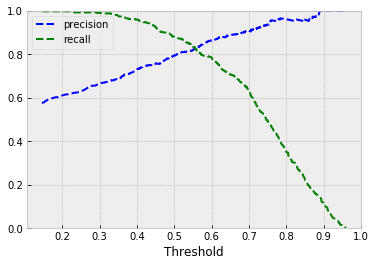

In [91]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds=precision_recall_curve(y_test,y_proba_1)
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plot_prec_recall_vs_tresh(precision, recall, thresholds)
plt.show()

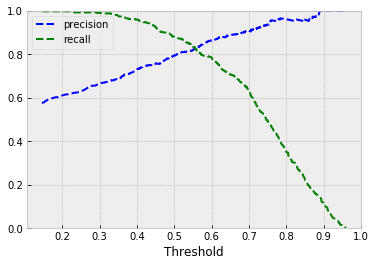

In [92]:
#performance
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def classification_metrics(y_true, y_pred, y_proba, target_names=['False', 'True']):
    
    #print(f'Zero class count:{len(y_true[y_true == 0])}')
    #print(f'One class count:{len(y_true[y_true == 1])}\n')
    
    columns = pd.MultiIndex.from_product([['Predicted Label'], target_names])
    index = pd.MultiIndex.from_product([['True Label'], target_names])
    display(pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=index))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(" ")
    print("=========================================================")
    print("Prediction simulation:")
    total_values = tn + fp + fn + tp
    print("True Highrated:{}".format((tp + fn) / total_values))
    print("Predicted Highrated:{}".format((tp + fp) / total_values))
    
    print("=========================================================")
    print(" ")
    
    print("Accuracy score: ",accuracy_score(y_true, y_pred))
    print("Balanced accuracy: {}".format(0.5*((tn/(tn+fn)) + (tp/(tp+fp)))))
    print(" ")
    
    print(classification_report(y_true, y_pred))
    print('ROC AUC: {}'.format(roc_auc_score(y_true, y_proba)))
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    plt.figure(figsize=(9,8))
    plt.plot(fpr, tpr)
    # Precision recall curve
    p, r, thresholds = precision_recall_curve(y_true, y_proba)
    plt.plot(r, p)
    plt.xlabel('FPR / Recall')
    plt.ylabel('TPR / Precision')
    plt.title('ROC / PR')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    # ROC AUC.

Predicted Label     
                           0    1
True Label 0             280   96
           1              51  371

 
Prediction simulation:
True Highrated:0.5288220551378446
Predicted Highrated:0.5852130325814536
 
Accuracy score:  0.8157894736842105
Balanced accuracy: 0.8201769991654644
 
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       376
           1       0.79      0.88      0.83       422

   micro avg       0.82      0.82      0.82       798
   macro avg       0.82      0.81      0.81       798
weighted avg       0.82      0.82      0.81       798

ROC AUC: 0.9051155843501058


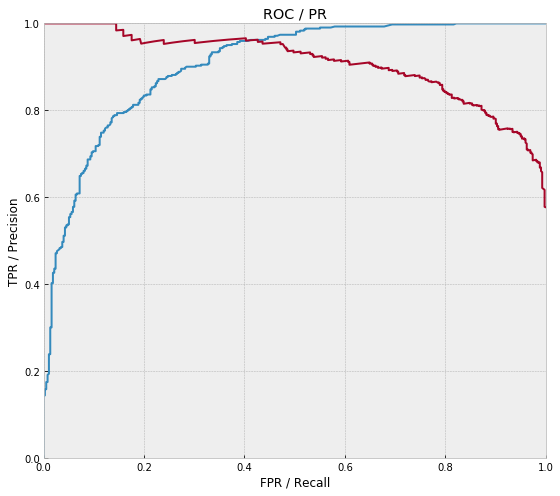

In [93]:
classification_metrics(y_test, pred, y_proba_1, target_names=[0, 1])   

In [81]:
features_test.columns[60:]

Index(['signal_x_Gyro_acf_std', 'signal_x_Gyro_acv_mean',
       'signal_x_Gyro_acv_std', 'signal_x_Gyro_jitter',
       'signal_x_Gyro_mean_crossing_rate', 'signal_y_Gyro_mean',
       'signal_y_Gyro_std', 'signal_y_Gyro_min', 'signal_y_Gyro_max',
       'signal_y_Gyro_median', 'signal_y_Gyro_skew', 'signal_y_Gyro_kurtosis',
       'signal_y_Gyro_acf_mean', 'signal_y_Gyro_acf_std',
       'signal_y_Gyro_acv_mean', 'signal_y_Gyro_acv_std',
       'signal_y_Gyro_jitter', 'signal_y_Gyro_mean_crossing_rate',
       'signal_z_Gyro_mean', 'signal_z_Gyro_std', 'signal_z_Gyro_min',
       'signal_z_Gyro_max', 'signal_z_Gyro_median', 'signal_z_Gyro_skew',
       'signal_z_Gyro_kurtosis', 'signal_z_Gyro_acf_mean',
       'signal_z_Gyro_acf_std', 'signal_z_Gyro_acv_mean',
       'signal_z_Gyro_acv_std', 'signal_z_Gyro_jitter',
       'signal_z_Gyro_mean_crossing_rate', 'magnitude_Gyro_mean',
       'magnitude_Gyro_std', 'magnitude_Gyro_min', 'magnitude_Gyro_max',
       'magnitude_Gyro_median', 

In [82]:



FEATURES_COLS = [
   'signal_x_Accel_mean', 'signal_x_Accel_std', 'signal_x_Accel_min',
       'signal_x_Accel_max', 'signal_x_Accel_median', 'signal_x_Accel_skew',
       'signal_x_Accel_kurtosis', 'signal_x_Accel_acf_mean',
       'signal_x_Accel_acf_std', 'signal_x_Accel_acv_mean',
       'signal_x_Accel_acv_std', 'signal_x_Accel_jitter',
       'signal_x_Accel_mean_crossing_rate', 'signal_y_Accel_mean',
       'signal_y_Accel_std', 'signal_y_Accel_min', 'signal_y_Accel_max',
       'signal_y_Accel_median', 'signal_y_Accel_skew',
       'signal_y_Accel_kurtosis', 'signal_y_Accel_acf_mean',
       'signal_y_Accel_acf_std', 'signal_y_Accel_acv_mean',
       'signal_y_Accel_acv_std', 'signal_y_Accel_jitter',
       'signal_y_Accel_mean_crossing_rate', 'signal_z_Accel_mean',
       'signal_z_Accel_std', 'signal_z_Accel_min', 'signal_z_Accel_max',
       'signal_z_Accel_median', 'signal_z_Accel_skew',
       'signal_z_Accel_kurtosis', 'signal_z_Accel_acf_mean',
       'signal_z_Accel_acf_std', 'signal_z_Accel_acv_mean',
       'signal_z_Accel_acv_std', 'signal_z_Accel_jitter',
       'signal_z_Accel_mean_crossing_rate', 'magnitude_Accel_mean',
       'magnitude_Accel_std', 'magnitude_Accel_min', 'magnitude_Accel_max',
       'magnitude_Accel_median', 'magnitude_Accel_skew',
       'magnitude_Accel_kurtosis', 'magnitude_Accel_acf_mean',
       'magnitude_Accel_acf_std', 'magnitude_Accel_acv_mean',
       'magnitude_Accel_acv_std', 'magnitude_Accel_jitter',
       'magnitude_Accel_mean_crossing_rate', 'signal_x_Gyro_mean',
       'signal_x_Gyro_std', 'signal_x_Gyro_min', 'signal_x_Gyro_max',
       'signal_x_Gyro_median', 'signal_x_Gyro_skew', 'signal_x_Gyro_kurtosis',
       'signal_x_Gyro_acf_mean',
       'signal_x_Gyro_acf_std', 'signal_x_Gyro_acv_mean',
       'signal_x_Gyro_acv_std', 'signal_x_Gyro_jitter',
       'signal_x_Gyro_mean_crossing_rate', 'signal_y_Gyro_mean',
       'signal_y_Gyro_std', 'signal_y_Gyro_min', 'signal_y_Gyro_max',
       'signal_y_Gyro_median', 'signal_y_Gyro_skew', 'signal_y_Gyro_kurtosis',
       'signal_y_Gyro_acf_mean', 'signal_y_Gyro_acf_std',
       'signal_y_Gyro_acv_mean', 'signal_y_Gyro_acv_std',
       'signal_y_Gyro_jitter', 'signal_y_Gyro_mean_crossing_rate',
       'signal_z_Gyro_mean', 'signal_z_Gyro_std', 'signal_z_Gyro_min',
       'signal_z_Gyro_max', 'signal_z_Gyro_median', 'signal_z_Gyro_skew',
       'signal_z_Gyro_kurtosis', 'signal_z_Gyro_acf_mean',
       'signal_z_Gyro_acf_std', 'signal_z_Gyro_acv_mean',
       'signal_z_Gyro_acv_std', 'signal_z_Gyro_jitter',
       'signal_z_Gyro_mean_crossing_rate', 'magnitude_Gyro_mean',
       'magnitude_Gyro_std', 'magnitude_Gyro_min', 'magnitude_Gyro_max',
       'magnitude_Gyro_median', 'magnitude_Gyro_skew',
       'magnitude_Gyro_kurtosis', 'magnitude_Gyro_acf_mean',
       'magnitude_Gyro_acf_std', 'magnitude_Gyro_acv_mean',
       'magnitude_Gyro_acv_std', 'magnitude_Gyro_jitter',
       'magnitude_Gyro_mean_crossing_rate', 'speed_GPS_mean', 'speed_GPS_std',
       'speed_GPS_min', 'speed_GPS_max', 'speed_GPS_median', 'speed_GPS_skew',
       'speed_GPS_kurtosis', 'speed_GPS_acf_mean', 'speed_GPS_acf_std',
       'speed_GPS_acv_mean', 'speed_GPS_acv_std', 'speed_GPS_jitter',
       'speed_GPS_mean_crossing_rate', 'course_GPS_mean', 'course_GPS_std',
       'course_GPS_min', 'course_GPS_max', 'course_GPS_median',
       'course_GPS_skew', 'course_GPS_kurtosis', 'course_GPS_acf_mean',
       'course_GPS_acf_std', 'course_GPS_acv_mean', 'course_GPS_acv_std',
       'course_GPS_jitter', 'course_GPS_mean_crossing_rate'

]


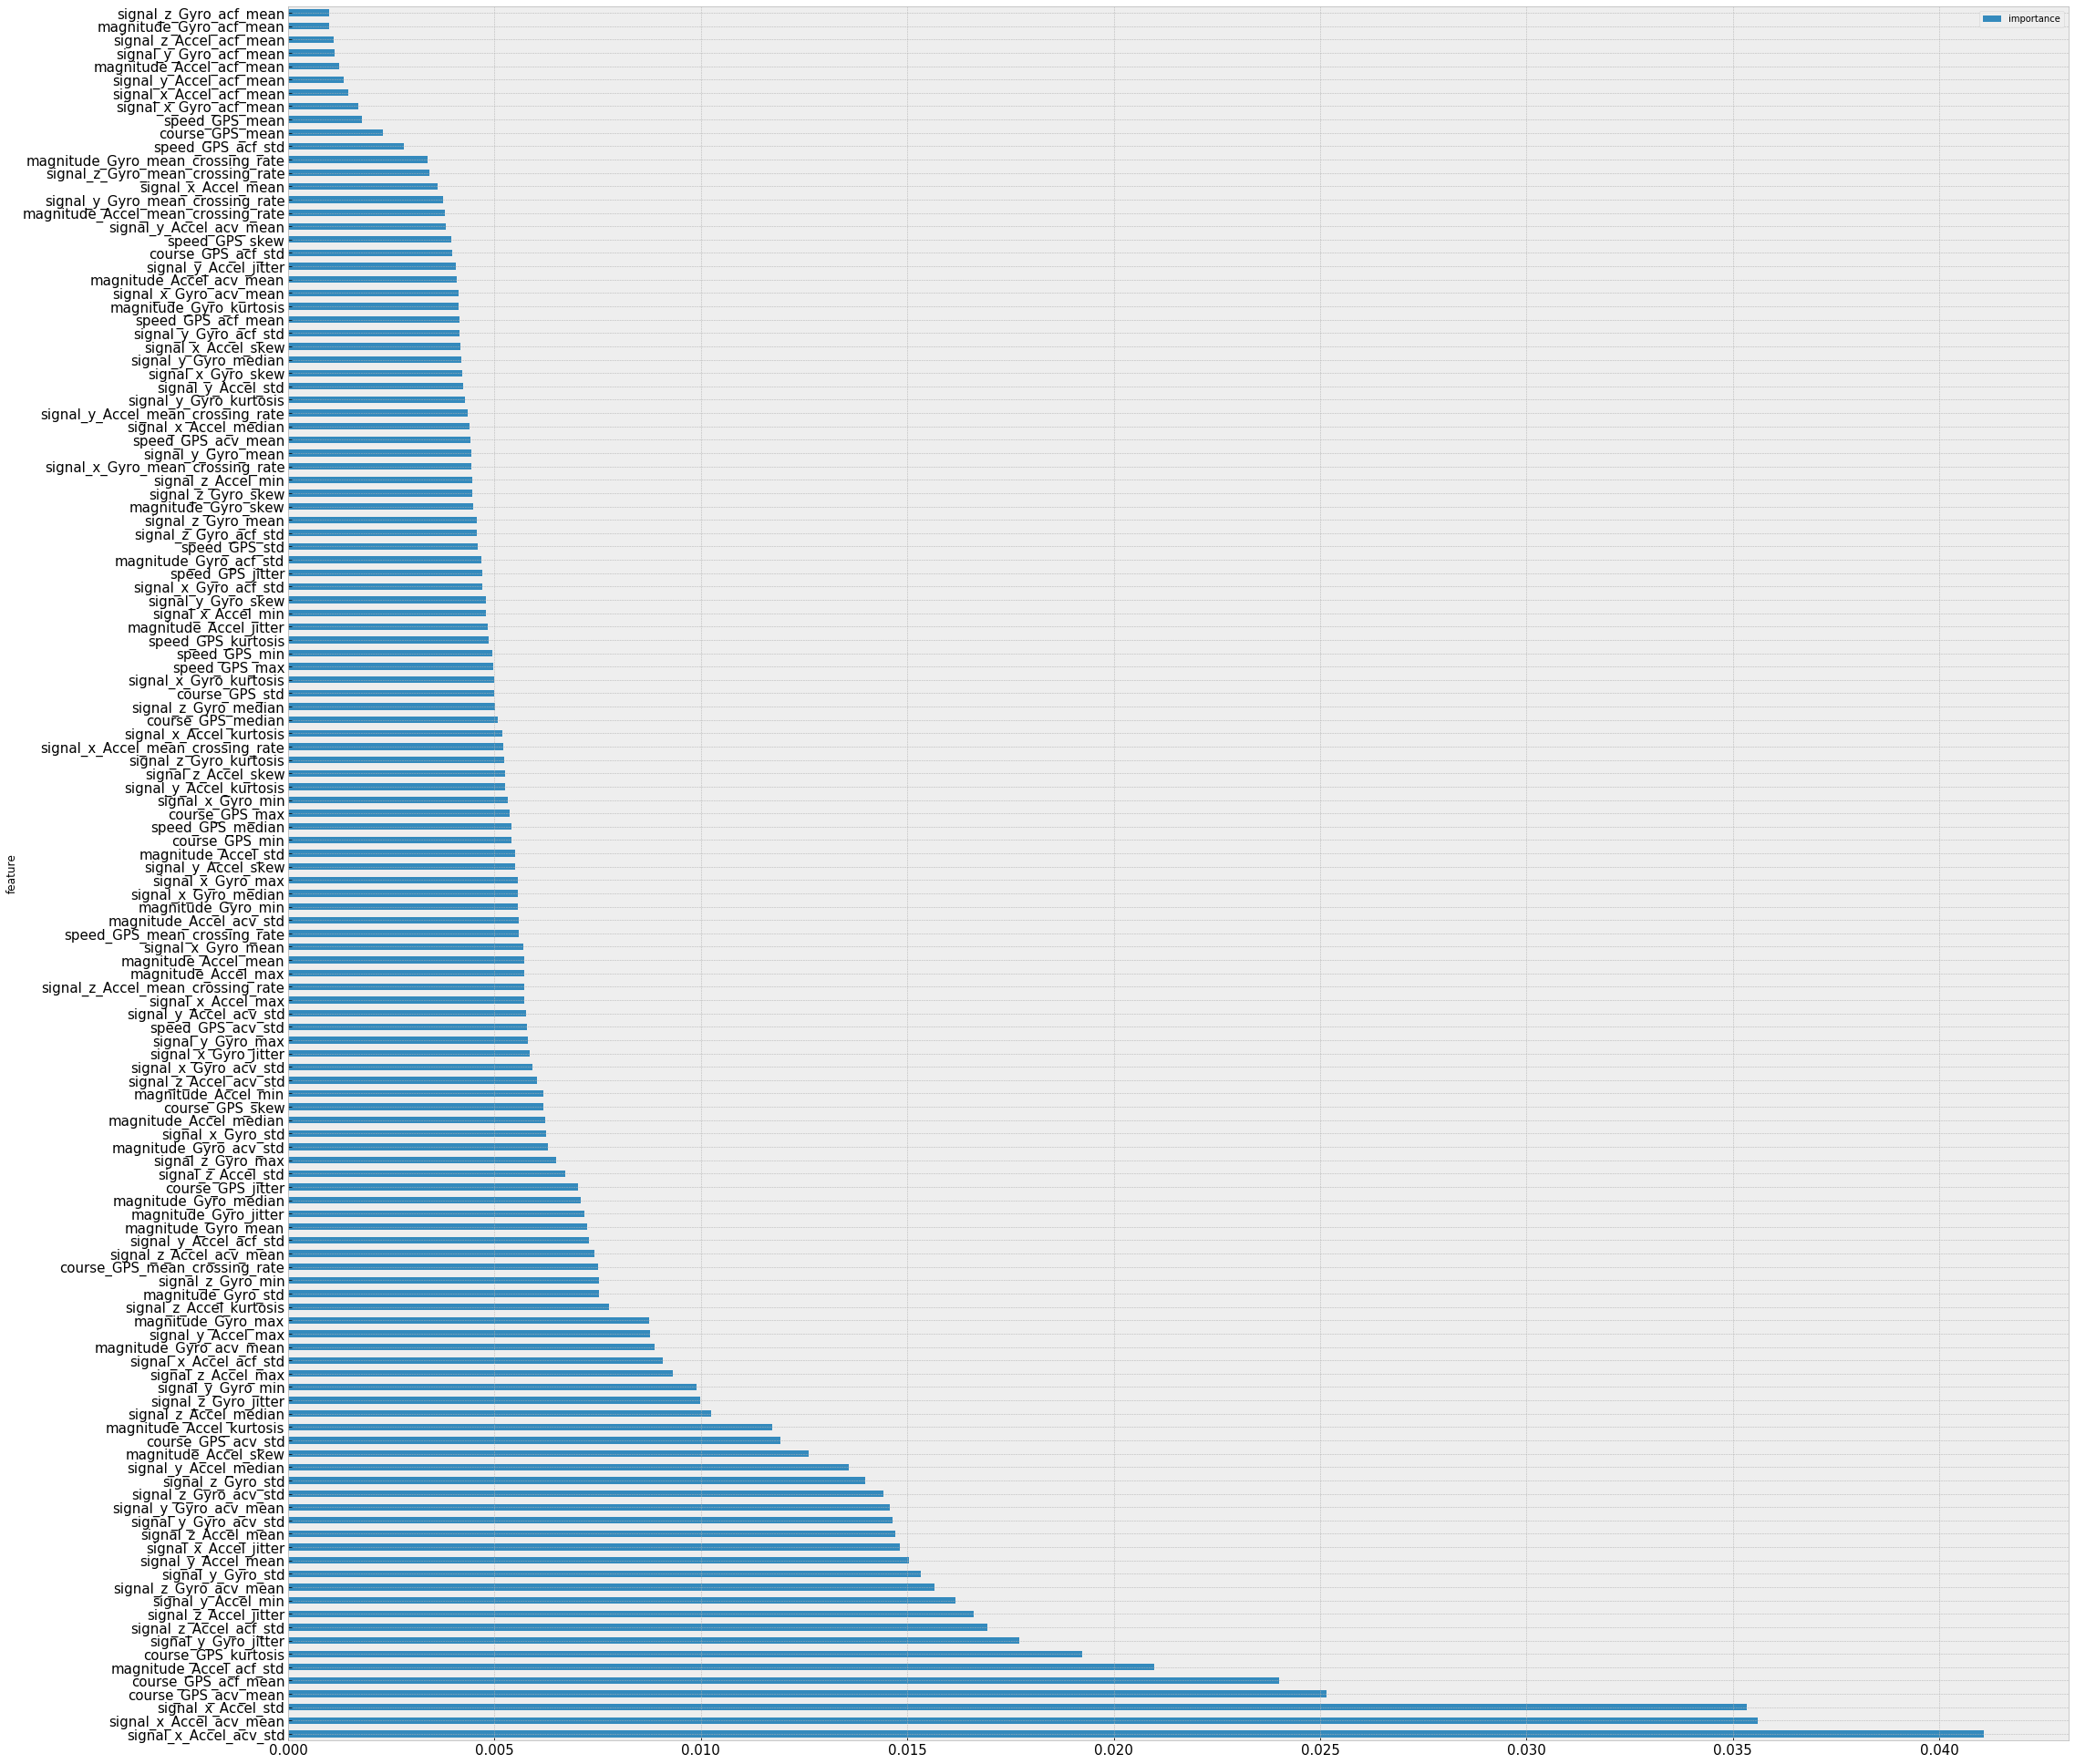

In [83]:
feature_importances = pd.Series(c.feature_importances_, index=FEATURES_COLS).sort_values(ascending=False)
feature_importance_df = pd.DataFrame(feature_importances)
feature_importance_df.reset_index(inplace=True)
feature_importance_df.columns = ['feature', 'importance']
feature_importance_df.set_index('feature').plot(kind='barh', figsize=(35, 35), fontsize=15)

### CHecking the additional test examples we got from Nexar. there are 100 high_rated and 100 zero_rated additional samples. We don't know which is which
## Note: For this part I need additional data of GPS/Gyro form Nexar in order to perform blind test 

In [85]:
!ls nexar
test_samples = glob.glob("nexar/*/*_Accel.csv")
test_samples[:10]
print("there are {} samples".format(len(test_samples)))

f1  f2	high_rated-2018-11-24  zero_rated-2018-11-24
there are 200 samples


In [86]:
def get_test_ids(fname):
    """Calculate `sample_id` and short filename."""
    start_dir, filename = os.path.split(fname)
    base_dir, sample_id = os.path.split(start_dir)
    _, sample_class = os.path.split(base_dir)
    sample_class= sample_class
    sample_class=filename.split("_")[0]
    return (sample_id, sample_class, filename)

In [87]:
get_test_ids(test_samples[0])
test_files = pd.DataFrame([get_test_ids(sample) for sample in test_samples],columns=["class", "sample_id", "accel_file"])

In [88]:
test_files.head()
f2=test_files[test_files["class"]=="f2"]
f1=test_files[test_files["class"]=="f1"]
f1.head()

,class,sample_id,accel_file
100,f1,b8da5016693d587883833c4a0405c0ed,b8da5016693d587883833c4a0405c0ed_Accel.csv
101,f1,b0ac3c4e524d0670b845c8db5f993db6,b0ac3c4e524d0670b845c8db5f993db6_Accel.csv
102,f1,b56a7f7ee5096a8f31de214afd03e12c,b56a7f7ee5096a8f31de214afd03e12c_Accel.csv
103,f1,b34fbd1cdc980499b4b53c4aea91f724,b34fbd1cdc980499b4b53c4aea91f724_Accel.csv
104,f1,b4e7191e747d4a494aa674e81de2df5a,b4e7191e747d4a494aa674e81de2df5a_Accel.csv


In [89]:
def generate_test_features(base_dir, sample_class, sample_id, filename):
    # Reading
    fullname = os.path.join(base_dir, sample_class, filename)
#     print("full name: {}".format(fullname))
    sample = pd.read_csv(fullname)
#     print(sample.shape)
#     print(sample.head()) 
    # Handling timestamps and spacing
    sample["timestamp"] = pd.to_datetime(sample['timestamp'], unit="s")
    
    
    
    sample = sample.resample('1S', on="timestamp").mean()
#     print(sample.shape)
#     print(sample.head())
    
    # Acceleration
    sample["magnitude"] = np.sqrt(np.square(sample).sum(axis=1))
    
    # Statistical aggregates

    # Note the trickery to get right format from pandas
    # without manual renaming
    aggs = (sample
            .apply(["mean", "std", "min", "max","median","skew","kurtosis",acf_mean,acf_std,acv_mean,acv_std,jitter,mean_crossing_rate])
            .unstack()
            .reset_index())
    aggs["feature"] = aggs["level_0"].str.cat(aggs["level_1"], sep="_")

    return aggs.set_index("feature")[0]
    

## get gyro and GPS data from nexar for this

In [64]:
features_test1=f1.apply(lambda f: generate_test_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)
features_test2=f2.apply(lambda f: generate_test_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)

NameError: name 'f1' is not defined

In [91]:
# def generate_features(base_dir, sample_class, sample_id, filename):

In [63]:
test1_pred =c.predict(features_test1)
test2_pred = c.predict(features_test2)


NameError: name 'features_test1' is not defined

In [ ]:
y1_proba=c.predict_proba(features_test1)
y2_proba=c.predict_proba(features_test2)

In [ ]:
df_yproba1=pd.DataFrame(y1_proba)
df_yproba2=pd.DataFrame(y2_proba)
df_yproba1.head()

In [137]:
print('predict majority class for unknown file f1')
print("mean proba for zero class {}".format(df_yproba1.loc[:,0].mean()))
print("mean proba for one class {}".format(df_yproba1.loc[:,1].mean()))


predict majority class for unknown file f1
mean proba for zero class 0.24520000000000014
mean proba for one class 0.7547999999999999


In [139]:
print('predict majority class for unknown file f2')
print("mean proba for zero class {}".format(df_yproba2.loc[:,0].mean()))
print("mean proba for one class {}".format(df_yproba2.loc[:,1].mean()))

predict majority class for unknown file f2
mean proba for zero class 0.6710499999999999
mean proba for one class 0.32895
